<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Sigmoid%20Neuron/Mobile%20Classification/MobileClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("drive/Udacity/Dataset/")
!ls

adc.json  drive  sample_data
E: Package 'python-software-properties' has no installation candidate
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
indian_liver_patient.csv  mobile.csv  student_data.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook

## Load Data

In [3]:
mobile = pd.read_csv('mobile.csv')


In [4]:
mobile.head()

,PhoneId,Pixel Density,Screen Size,Weight,RAM,Processor_frequency,Screen to Body Ratio (calculated),Height,Internal Memory,Capacity,Resolution,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,...,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Rating
0,0,403,6.26,182,4,1.8,80.68,157.9,64,4000,20,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.5
1,1,271,6.20,168,3,1.8,80.85,156.2,32,4230,8,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.5
2,2,409,6.30,168,3,2.1,83.68,157.0,32,3500,25,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.4
3,4,411,6.00,169,4,2.2,74.78,159.8,64,3300,24,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,4.3
4,5,396,6.50,175,4,2.2,84.23,160.4,64,3750,16,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,4.4


In [5]:
mobile.describe()

,PhoneId,Pixel Density,Screen Size,Weight,RAM,Processor_frequency,Screen to Body Ratio (calculated),Height,Internal Memory,Capacity,Resolution,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,...,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Sim1_2G,Sim1_3G,Sim1_4G,Rating
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,...,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,232.970674,344.211144,5.462317,161.343109,11.120235,1.792551,72.353343,149.946394,46.369501,3191.307918,9.592375,0.211144,0.020528,0.683284,0.085044,0.002933,0.005865,0.029326,0.035191,0.580645,0.017595,0.325513,0.002933,0.005865,0.055718,0.023460,0.0,0.014663,0.002933,0.005865,0.0,0.029326,0.011730,0.017595,0.049853,0.017595,0.008798,0.008798,0.011730,0.011730,...,0.005865,0.043988,0.011730,0.043988,0.005865,0.061584,0.002933,0.041056,0.008798,0.017595,0.011730,0.002933,0.011730,0.002933,0.129032,0.026393,0.0,0.023460,0.002933,0.002933,0.076246,0.061584,0.008798,0.011730,0.002933,0.906158,0.005865,0.005865,0.002933,0.020528,0.002933,0.055718,0.002933,0.759531,0.152493,0.085044,0.020528,0.020528,0.958944,4.072434
std,137.231746,88.161129,0.742529,22.305556,61.320855,0.451598,9.357839,9.192305,46.435453,932.533527,5.953827,0.408720,0.142006,0.465879,0.279357,0.054153,0.076471,0.168965,0.184532,0.494179,0.131668,0.469255,0.054153,0.076471,0.229714,0.151583,0.0,0.120375,0.054153,0.076471,0.0,0.168965,0.107827,0.131668,0.217962,0.131668,0.093520,0.093520,0.107827,0.107827,...,0.076471,0.205370,0.107827,0.205370,0.076471,0.240751,0.054153,0.198711,0.093520,0.131668,0.107827,0.054153,0.107827,0.054153,0.335728,0.160536,0.0,0.151583,0.054153,0.054153,0.265782,0.240751,0.093520,0.107827,0.054153,0.292037,0.076471,0.076471,0.054153,0.142006,0.054153,0.229714,0.054153,0.427996,0.360026,0.279357,0.142006,0.142006,0.198711,0.377066
min,0.000000,143.000000,2.400000,58.000000,1.000000,1.000000,23.600000,115.600000,0.000000,1020.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000

In [6]:
mobile['Rating'].value_counts()

4.3    44
4.1    41
4.4    41
4.0    38
4.2    33
3.9    29
4.5    25
3.8    16
3.7    14
3.4    11
4.6    10
3.5    10
3.6     8
3.3     5
3.0     4
2.8     2
4.8     2
5.0     2
3.1     2
4.7     2
3.2     1
2.5     1
Name: Rating, dtype: int64

In [7]:
X = mobile[mobile.columns.difference(['PhoneId','Rating'])]

In [8]:
Y = mobile['Rating'].values

In [9]:
threshold = 4.2
mobile['Class'] = (mobile['Rating'] >= threshold).astype(np.int)

In [10]:
mobile['Class'].value_counts()

0    182
1    159
Name: Class, dtype: int64

In [11]:
mobile['Class'].value_counts(normalize=True)

0    0.533724
1    0.466276
Name: Class, dtype: float64

In [12]:
Y_binarised = mobile['Class'].values

## Train Test Split

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, stratify=Y_binarised)
print(X_train.shape, X_test.shape)

(255, 86) (86, 86)


## Standardisation

In [14]:
R = np.random.random([100, 1])

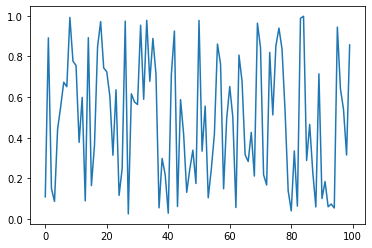

In [15]:
plt.plot(R)
plt.show()

In [16]:
print("Mean of R is : ", np.mean(R))
print("Std Deviation of R is : ", np.std(R))

Mean of R is :  0.49102333776636314
Std Deviation of R is :  0.31148455007352666


In [17]:
scaler = StandardScaler()
scaler.fit(R)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
print("Mean of R is : ", scaler.mean_)

Mean of R is :  [0.49102334]


In [19]:
RT = scaler.transform(R)

In [20]:
np.mean(RT)

-1.5765166949677222e-16

In [21]:
np.std(RT)

1.0

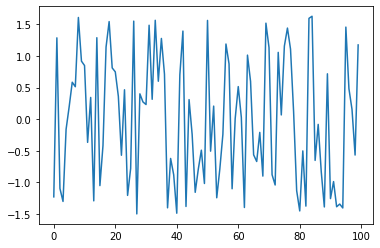

In [22]:
plt.plot(RT)
plt.show()

In [23]:
scaler = StandardScaler()

In [24]:
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [25]:
print("Y_train vector is : ", Y_train.shape)
print("Y_train matrix is : ", Y_train.reshape(-1, 1).shape)

Y_train vector is :  (255,)
Y_train matrix is :  (255, 1)


In [26]:
minmax_scaler = MinMaxScaler()

In [27]:
Y_scaled_train = minmax_scaler.fit_transform(Y_train.reshape(-1, 1))
Y_scaled_test = minmax_scaler.transform(Y_test.reshape(-1, 1))

In [28]:
np.min(Y_scaled_train)

0.0

In [29]:
print(threshold) #scalor
print(np.array([threshold])) #vector
print(np.array([threshold]).reshape(1, -1)) #matrix
threshold = np.array([threshold]).reshape(1, -1)

4.2
[4.2]
[[4.2]]


In [30]:
scaled_threshold = list(minmax_scaler.transform(threshold))[0][0]
scaled_threshold

0.6800000000000002

In [31]:
Y_binarised_train = (Y_scaled_train > scaled_threshold).astype("int").ravel()
Y_binarised_test = (Y_scaled_test > scaled_threshold).astype("int").ravel()

## Model

In [32]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        dw += self.grad_w(x, y)
        db += self.grad_b(x, y)       
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        loss[i] = mean_squared_error(Y_pred, Y)
    
    if display_loss:
      plt.plot(list(loss.values()))
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


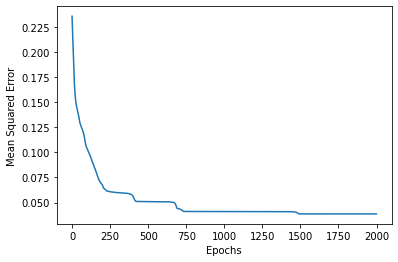

In [33]:
sn = SigmoidNeuron()
sn.fit(X_scaled_train, Y_scaled_train, epochs=2000, learning_rate=0.015, display_loss=True)

In [34]:
Y_pred_train = sn.predict(X_scaled_train)
Y_pred_test = sn.predict(X_scaled_test)

In [35]:
Y_pred_binarised_train = (Y_pred_train > scaled_threshold).astype("int").ravel()
Y_pred_binarised_test = (Y_pred_test > scaled_threshold).astype("int").ravel()

In [36]:
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_binarised_train)
accuracy_test  = accuracy_score(Y_pred_binarised_test, Y_binarised_test)
print(accuracy_train, accuracy_test)

0.796078431372549 0.7093023255813954
